In [1]:
# Predict student admissions to graduate school based on three pieces of data:
#1.) GRE Scores (Test)
#2.) GPA Scores (Grades)
#3.) Class rank (1-4)

In [2]:
#Importing pandas, numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Reading in the student data csv file
data = pd.read_csv('student_data.csv')

data[:10]

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


In [4]:
# Defining plot points to visualize the data and get an initial impression.

def plot_points(data):
    X = np.array(data[['gre', 'gpa']])
    y = np.array(data['admit'])
    #differintiating between admitted and rejected students using the 'admit' column.
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s=25, color = 'blue', edgecolor='k')
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s=25, color = 'red', edgecolor='k')
    plt.xlabel('Grade(GRE)')
    plt.ylabel('Test(GPA)')
    plt.show()

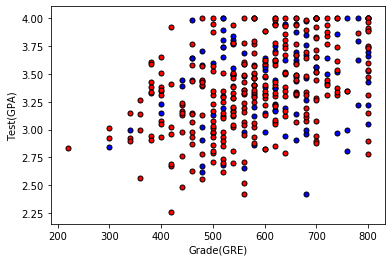

In [5]:
#Plotting the data
plot_points(data)
plt.show()

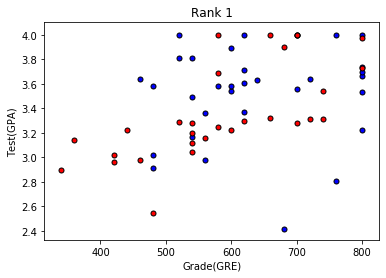

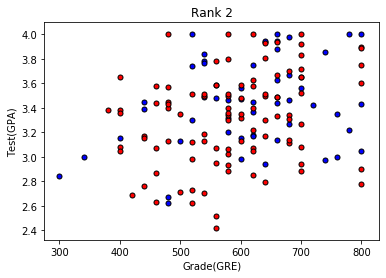

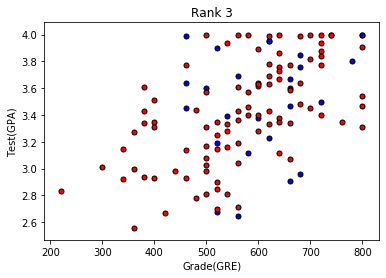

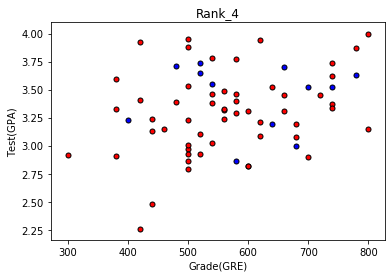

In [7]:
# The data is not well seperated and therefore needs to be seperated into
#ranks to increase visibility.
rank_1 = data[data['rank']==1]
rank_2 = data[data['rank']==2]
rank_3 = data[data['rank']==3]
rank_4 = data[data['rank']==4]

#Using the plot_points function to plot each rank on seperate graphs
plt.title('Rank 1')
plot_points(rank_1)
plt.show()
plt.title('Rank 2')
plot_points(rank_2)
plt.show()
plt.title('Rank 3')
plot_points(rank_3)
plt.show()
plt.title('Rank_4')
plot_points(rank_4)
plt.show()

In [10]:
#Performing One hot encoding on data for preprocessing categorical features
#for the model
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'])], axis=1)

#Dropping the initial ranking data 
one_hot_data = one_hot_data.drop('rank', axis=1)

one_hot_data[:10]

,admit,gre,gpa,1,2,3,4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1
5,1,760,3.00,0,1,0,0
6,1,560,2.98,1,0,0,0
7,0,400,3.08,0,1,0,0
8,1,540,3.39,0,0,1,0
9,0,700,3.92,0,1,0,0


In [13]:
#Next step requires processing data to range from 0 to 1
print('Highest gpa:', data['gpa'].max())
print('Highest gre score:', data['gre'].max())

Highest gpa: 4.0
Highest gre score: 800


In [14]:
processed_data = one_hot_data[:]

processed_data['gre'] = processed_data['gre']/800
processed_data['gpa'] = processed_data['gpa']/4

processed_data[:10]

,admit,gre,gpa,1,2,3,4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1
5,1,0.950,0.7500,0,1,0,0
6,1,0.700,0.7450,1,0,0,0
7,0,0.500,0.7700,0,1,0,0
8,1,0.675,0.8475,0,0,1,0
9,0,0.875,0.9800,0,1,0,0


In [15]:
#Dividing data into test_data and train_data using np.random.choice
#function
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=None)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print('Total amount of train data:', len(train_data))
print('Total amount of test data:', len(test_data))

Total amount of train data: 360
Total amount of test data: 40


In [39]:
features = train_data.drop('admit', axis=1)
targets = train_data['admit']

test_features = test_data.drop('admit', axis=1)
test_targets = test_data['admit']


In [40]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))
def error_formula(y, output):
    return - y * np.log(output) + (1 - y) * np.log(1-output)

In [41]:
def error_term_formula(x, y, output):
    return (y - output) * (sigmoid_prime(x))

In [42]:
epochs = 1000
learnrate = 0.5

# Training function
def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features.values, targets):
            # Loop through all records, x is the input, y is the target

            # Activation of the output unit
            #   Notice we multiply the inputs and the weights here 
            #   rather than storing h as a separate variable 
            output = sigmoid(np.dot(x, weights))

            # The error, the target minus the network output
            error = error_formula(y, output)

            # The error term
            #   Notice we calulate f'(h) here instead of defining a separate
            #   sigmoid_prime function. This just makes it faster because we
            #   can re-use the result of the sigmoid function stored in
            #   the output variable
            error_term = error_term_formula(x, y, output)

            # The gradient descent step, the error times the gradient times the inputs
            del_w += error_term * x

        # Update the weights here. The learning rate times the 
        # change in weights, divided by the number of records to average
        weights += learnrate * del_w / n_records
    

        # Printing out the mean square error on the training set
        if e % (epochs / 10) == 0:
            out = sigmoid(np.dot(features, weights))
            loss = np.mean((out - targets) ** 2)
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights
    
weights = train_nn(features, targets, epochs, learnrate)


Epoch: 0
Train loss:  0.2712224583806555
Epoch: 100
Train loss:  0.2145809973351646
Epoch: 200
Train loss:  0.21247173967486963
Epoch: 300
Train loss:  0.2114140900768867
Epoch: 400
Train loss:  0.2108383922458761
Epoch: 500
Train loss:  0.2104832838578662
Epoch: 600
Train loss:  0.21023192094491552
Epoch: 700
Train loss:  0.2100314778219979
Epoch: 800
Train loss:  0.20985754860719757
Epoch: 900
Train loss:  0.20969858530142593
Finished training!


In [43]:
testing = sigmoid(np.dot(test_features, weights))
predictions = testing > 0.5
accuracy = np.mean(predictions == test_targets)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.800
